In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.2 MB/s eta 0:00:00


In [ ]:
#importing all the essential libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import re #for data pre-processing
import unicodedata #library for data pre-processing
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
#mounting drive to collab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading file from drive
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/instagram.csv')

In [ ]:
df.head()

,review_description,rating,review_date
0,"The app is good for connecting with friends, f...",3,2023-07-11 23:57:07
1,"Used to be my favorite social media app, but ""...",2,2023-07-22 21:37:09
2,Instagram is the best of all the social media....,5,2023-07-25 03:24:58
3,"I love this app.. but as of late, I have been ...",2,2023-07-09 04:49:57
4,Used to be a great app but there are so many m...,3,2023-07-17 16:47:04


In [ ]:
df['rating'] = df['rating'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else x))

In [ ]:
df.head()

,review_description,rating,review_date
0,"The app is good for connecting with friends, f...",3,2023-07-11 23:57:07
1,"Used to be my favorite social media app, but ""...",0,2023-07-22 21:37:09
2,Instagram is the best of all the social media....,1,2023-07-25 03:24:58
3,"I love this app.. but as of late, I have been ...",0,2023-07-09 04:49:57
4,Used to be a great app but there are so many m...,3,2023-07-17 16:47:04


In [ ]:
# Geting unique values in the "Sentiment" column
unique_values = df['rating'].unique()

print(unique_values)


[3 0 1]


In [ ]:
#checking for any null values
df['rating'].value_counts()

0    120550
1     63460
3     26532
Name: rating, dtype: int64

In [ ]:
Sentiment_0 = df[df['rating'] == 0]
Sentiment_1 = df[df['rating'] == 1]

#Selecting Equal no of Positive and Negative Reviews
num_samples = 25000
sample_df = pd.concat([Sentiment_0.sample(n=num_samples, random_state=42),
                        Sentiment_1.sample(n=num_samples, random_state=42)])

# Shuffling the sampled DataFrame
df = sample_df.sample(frac=1, random_state=42)

df.head()

,review_description,rating,review_date
163899,The best ever app inverted,1,2023-07-26 09:20:00
24737,I use it on a daily basis and it's the only pl...,0,2022-07-15 20:01:54
123022,"DO NOT DOWNLOAD. If you connect to the wifi, i...",0,2023-03-25 00:20:16
163317,Doesn't fully load when opened. Must open and ...,0,2019-01-20 00:47:22
60708,Its such a cool app because i get chat with my...,1,2023-03-30 05:22:03


In [ ]:
df['rating'].value_counts()

1    25000
0    25000
Name: rating, dtype: int64

In [ ]:
#Assigning X & y with review and sentiment respectively

X = df['review_description']
y = df['rating']

In [ ]:
#splitting values in to train, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7,stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.57, random_state=42)

In [ ]:
#chceking the length of the train, validation and test sets

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 15000
Test set size: 19950
Validation set size: 15050


In [ ]:
#seeing the index locations for the variables

print(X_train.index)
print(X_test.index)
print(X_val.index)

Int64Index([167086, 208038,  73605, 185533,  86507,   1981,  70463, 177320,
            163643, 186525,
            ...
             96675,  64352, 112981, 151710,  48248,  11590,  66954, 198628,
             42977, 141143],
           dtype='int64', length=15000)
Int64Index([ 21176, 159220, 109673,   5779, 209331, 173612, 142774,  26098,
             43149,  84386,
            ...
             94719, 161848,  16797,  94959, 140434,  31445, 177977,  60995,
             68905, 118582],
           dtype='int64', length=19950)
Int64Index([121642, 120369,  14567,  56214, 194715,  10931,  61174, 130277,
            151630,  17152,
            ...
            131717,  48845,  58481, 182171, 141207, 163631, 210286, 132698,
            208344, 143460],
           dtype='int64', length=15050)


In [ ]:
#resetting the index locations

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [ ]:
# Verifying the updated index values

print(X_train.index)
print(X_test.index)
print(X_val.index)

RangeIndex(start=0, stop=15000, step=1)
RangeIndex(start=0, stop=19950, step=1)
RangeIndex(start=0, stop=15050, step=1)


In [ ]:
#Printing the data brfore pre processing

print(X_train[0])
print(X_test[0])
print(X_val[0])

Awesome aap and I like this app very much ❤️❤️❤️❤️❤️❤️❤️
Instagram is best platform for comparison to all online platforms. This so owsome. I like it very much
Restricted my account unnecesaarily i want my id back . Since 1 hour i am trying to login but no security codes has been sent . I want my problem to be resolved today itself .


In [ ]:
#seeing the index locations for the variables

print(y_train.index)
print(y_test.index)
print(y_val.index)

Int64Index([167086, 208038,  73605, 185533,  86507,   1981,  70463, 177320,
            163643, 186525,
            ...
             96675,  64352, 112981, 151710,  48248,  11590,  66954, 198628,
             42977, 141143],
           dtype='int64', length=15000)
Int64Index([ 21176, 159220, 109673,   5779, 209331, 173612, 142774,  26098,
             43149,  84386,
            ...
             94719, 161848,  16797,  94959, 140434,  31445, 177977,  60995,
             68905, 118582],
           dtype='int64', length=19950)
Int64Index([121642, 120369,  14567,  56214, 194715,  10931,  61174, 130277,
            151630,  17152,
            ...
            131717,  48845,  58481, 182171, 141207, 163631, 210286, 132698,
            208344, 143460],
           dtype='int64', length=15050)


In [ ]:
#resetting the index locations

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [ ]:
print(y_train.index)
print(y_test.index)
print(y_val.index)

RangeIndex(start=0, stop=15000, step=1)
RangeIndex(start=0, stop=19950, step=1)
RangeIndex(start=0, stop=15050, step=1)


In [ ]:
print(y_train[0])
print(y_test[0])
print(y_val[0])

1
1
0


In [ ]:
def preprocess_text(text):
    # Removing HTML tags
    text = re.sub('<.*?>', '', text)

    # Removing accented characters by normalizing to ASCII
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Replacing patterns like n't, nt, and n t with not
    text = re.sub(r"\b(n['’]?t|n\s?t)\b", ' not', text)

    # Removing special characters
    text = re.sub("[^a-zA-Z0-9,'!]", ' ', text)

    # Converting text to lowercase
    text = text.lower()

    # Separating text into sentences based on punctuations and then removing punctuations
    sentences = re.split(r'[.!?]', text)
    sentences = [re.sub('[,]', '', sentence) for sentence in sentences]

    # Removing extra spaces
    text = ' '.join(' '.join(sentence.split()) for sentence in sentences)

    return text

In [ ]:
# Preprocessing the data

X_train_preprocessed = [preprocess_text(text) for text in X_train]

X_test_preprocessed = [preprocess_text(text) for text in X_test]

X_val_preprocessed = [preprocess_text(text) for text in X_val]


In [ ]:
#Printing pre processed data

print(X_train_preprocessed[0])
print(X_test_preprocessed[0])
print(X_val_preprocessed[0])

awesome aap and i like this app very much
instagram is best platform for comparison to all online platforms this so owsome i like it very much
restricted my account unnecesaarily i want my id back since 1 hour i am trying to login but no security codes has been sent i want my problem to be resolved today itself


Tokenizing and creating datasets for train, validation and test sets so they can be used through out different types of training sessions and evaluation of diferent models

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenizing and encoding the train data
X_train_encoded = tokenizer.batch_encode_plus(
    X_train_preprocessed,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)
# Tokenizing and encoding the validation data
X_val_encoded = tokenizer.batch_encode_plus(
    X_val_preprocessed,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

In [ ]:
# Extracting input tensors from the encoded data
input_ids_train = X_train_encoded['input_ids']
attention_masks_train = X_train_encoded['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_val = X_val_encoded['input_ids']
attention_masks_val = X_val_encoded['attention_mask']
labels_val = torch.tensor(y_val.values)

# Creating datasets
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
# Tokenizing and encoding the test data
X_test_encoded = tokenizer.batch_encode_plus(
    X_test_preprocessed,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

In [ ]:
# Extracting input tensors and attention masks from the encoded data

input_ids_test = X_test_encoded['input_ids']
attention_masks_test = X_test_encoded['attention_mask']
labels_test = torch.tensor(y_test.values)

# Creating datasets
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
# Setting the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Adam Optimizer

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# declaring Hyperparameters
batch_size = 64
early_stopping_patience = 3
epochs_without_improvement = 0
num_cpu = 12
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBAOInstagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.36776474471886955, Validation Accuracy: 0.8722259136212624
Epoch 2/5, Loss: 0.2717736857414246, Validation Accuracy: 0.8706312292358804
Epoch 3/5, Loss: 0.20514849356810252, Validation Accuracy: 0.8710963455149502
Early stopping triggered.


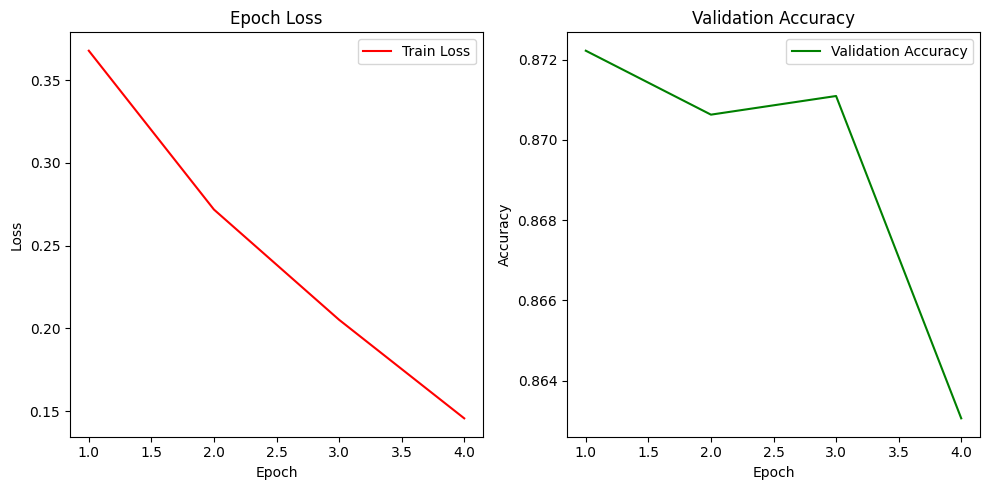

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBAO_plotInstagram.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBAOInstagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 86.51%
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.89      0.87     10012
    positive       0.88      0.84      0.86      9938

    accuracy                           0.87     19950
   macro avg       0.87      0.87      0.86     19950
weighted avg       0.87      0.87      0.87     19950

Confusion Matrix:
 [[8928 1084]
 [1607 8331]]


# 2 Adam Optimizer with Cosine Anneaing LR Scheduler




In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# declaring Hyperparameters
batch_size = 64
early_stopping_patience = 3
epochs_without_improvement = 0
num_cpu = 12
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    scheduler.step()


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBAO1Instagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.3480418262799581, Validation Accuracy: 0.8774086378737541
Epoch 2/5, Loss: 0.25979313906033835, Validation Accuracy: 0.8756146179401993
Epoch 3/5, Loss: 0.19714073884487152, Validation Accuracy: 0.8730232558139535
Early stopping triggered.


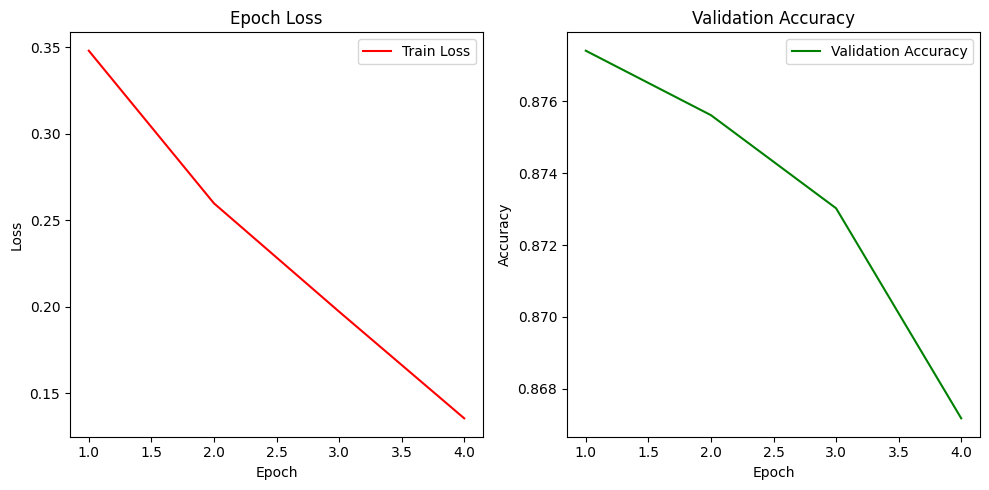

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBAO1Instagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBAO1Instagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 87.01%
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.89      0.87     10012
    positive       0.88      0.85      0.87      9938

    accuracy                           0.87     19950
   macro avg       0.87      0.87      0.87     19950
weighted avg       0.87      0.87      0.87     19950

Confusion Matrix:
 [[8906 1106]
 [1486 8452]]


# 3 Lamb Optimizer with Exponential LR Scheduler




In [ ]:
!pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
from torch_optimizer import Lamb
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# declaring Hyperparameters
batch_size = 64
early_stopping_patience = 3
epochs_without_improvement = 0
num_cpu = 12
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = Lamb(model.parameters(), lr= 2e-5)
scheduler = ExponentialLR(optimizer, gamma=0.95)

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    scheduler.step()


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBLOInstagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.6376964145978292, Validation Accuracy: 0.792093023255814
Epoch 2/5, Loss: 0.47590422689119977, Validation Accuracy: 0.8341528239202658
Epoch 3/5, Loss: 0.4046995062192281, Validation Accuracy: 0.848970099667774
Epoch 4/5, Loss: 0.3733270892620087, Validation Accuracy: 0.8567441860465116
Epoch 5/5, Loss: 0.3551274980545044, Validation Accuracy: 0.8606644518272425


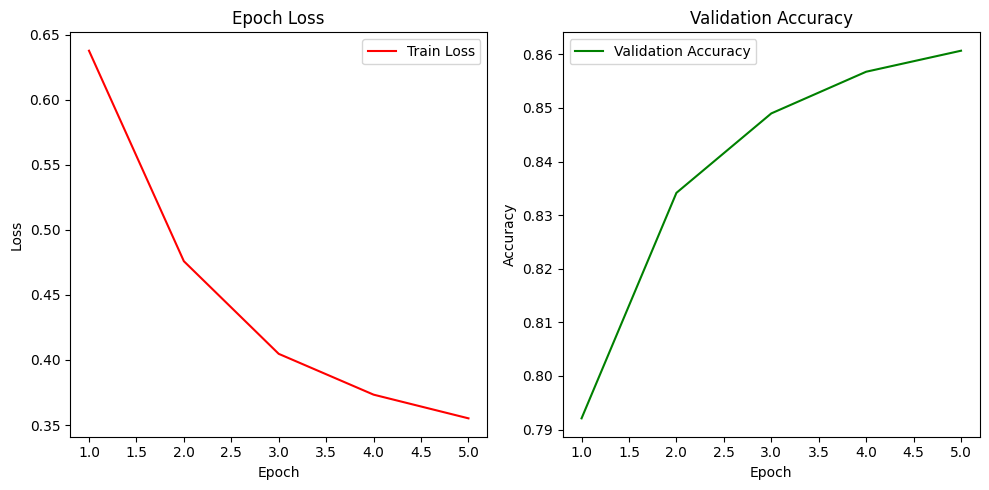

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBLOInstagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBLOInstagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 86.34%
Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.91      0.87     10012
    positive       0.90      0.82      0.86      9938

    accuracy                           0.86     19950
   macro avg       0.87      0.86      0.86     19950
weighted avg       0.87      0.86      0.86     19950

Confusion Matrix:
 [[9077  935]
 [1790 8148]]


# 4 Adagrad Optimizer with Reduce LR on Plataeu LR Scheduler




In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

batch_size = 64
num_cpu = 12

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# declaring Hyperparameters

early_stopping_patience = 3
epochs_without_improvement = 0
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optimizer = optim.Adagrad(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    scheduler.step(epoch_loss)


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBAGInstagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.45210462919871014, Validation Accuracy: 0.846843853820598
Epoch 2/5, Loss: 0.3625570888678233, Validation Accuracy: 0.8544186046511628
Epoch 3/5, Loss: 0.34140191073417664, Validation Accuracy: 0.858671096345515
Epoch 4/5, Loss: 0.32757833371162415, Validation Accuracy: 0.8613953488372093
Epoch 5/5, Loss: 0.31850531383355457, Validation Accuracy: 0.8625913621262459


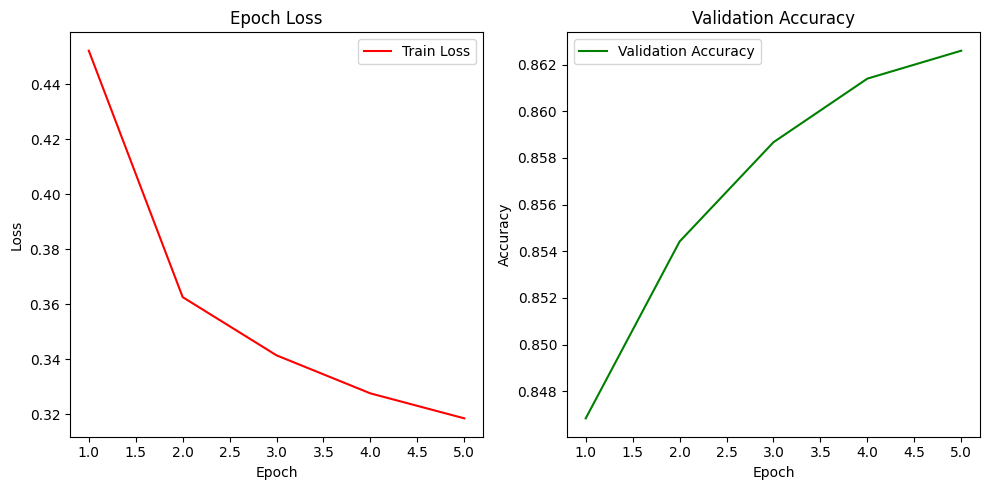

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBAGInstagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBAGInstagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 86.73%
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.89      0.87     10012
    positive       0.88      0.85      0.86      9938

    accuracy                           0.87     19950
   macro avg       0.87      0.87      0.87     19950
weighted avg       0.87      0.87      0.87     19950

Confusion Matrix:
 [[8904 1108]
 [1540 8398]]


# 5 AdamW Optimizer with get linear schedule with warm up LR Scheduler




In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

batch_size = 64
num_cpu = 12

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# declaring Hyperparameters

early_stopping_patience = 3
epochs_without_improvement = 0
num_epochs = 5
steps_per_epoch = len(train_dataloader)
total_steps = num_epochs * steps_per_epoch
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-08)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    scheduler.step()


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBAWInstagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.74114873863856, Validation Accuracy: 0.49940199335548174
Epoch 2/5, Loss: 0.6911964806556702, Validation Accuracy: 0.626843853820598
Epoch 3/5, Loss: 0.6004980027198792, Validation Accuracy: 0.7749501661129569
Epoch 4/5, Loss: 0.4734803378582001, Validation Accuracy: 0.8315614617940199
Epoch 5/5, Loss: 0.39914679948488874, Validation Accuracy: 0.8499003322259137


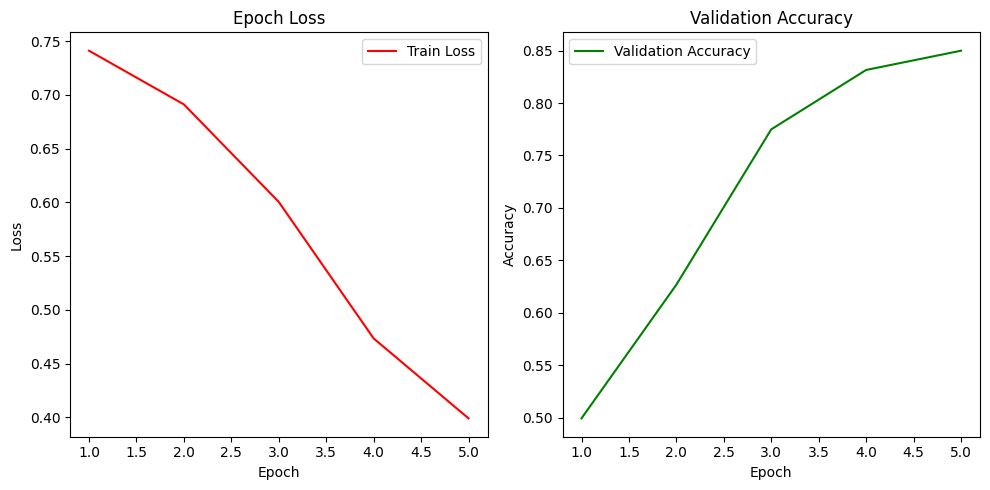

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBAWInstagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBAWInstagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 85.53%
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.89      0.86     10012
    positive       0.88      0.82      0.85      9938

    accuracy                           0.86     19950
   macro avg       0.86      0.86      0.86     19950
weighted avg       0.86      0.86      0.86     19950

Confusion Matrix:
 [[8901 1111]
 [1775 8163]]


In [ ]:
user_input = input("Enter a sentence: ")
preprocessed_input = preprocess_text(user_input)
encoded_input= tokenizer.batch_encode_plus(
    [preprocessed_input],
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)
input_ids = encoded_input['input_ids'].to(device)
attention_masks_test = encoded_input['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks_test)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

class_names = ["negative", "positive"]
predicted_sentiment = class_names[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

Enter a sentence: good
Predicted sentiment: positive
